# Calculating attribution scores per ROI

In [2]:
import copy
import numpy as np 
import pandas as pd

import glob 
import matplotlib.pyplot as plt
import numpy as np 
import os 

import nibabel as nib
import json

from monai.transforms import Compose, AddChannel, Resize 
from tqdm import tqdm
%matplotlib inline


In [105]:

def extracting_score(mask_img_dir, subject_list, subject_file_list): 
    # loading mask image
    mask = nib.load(mask_img_dir) 
    mask = np.array(mask.dataobj)

    # calculating mean attribution scores per ROI 
    seg_attr_result = {}
    for i in tqdm(np.unique(mask)):
        if i == 0: 
            pass 
        else:  
            seg_mask = np.where(mask != i, 0, 1)
            transform = Compose([AddChannel(), Resize((128, 128, 128))])
            seg_mask = transform(seg_mask)[0, :, :, :] 
            seg_subj_attr_result = []
            for subj in subject_file_list: 
                # standardizing subject's attribution score across the whole brain
                subj_img = np.load(subj)
                subj_img = (subj_img - np.mean(subj_img)) / np.std(subj_img)
                # masking ROI
                seg_subj_attr = subj_img * seg_mask
                # calculating mean attr score per ROI
                if np.sum(seg_mask) == 0: 
                    seg_subj_attr_norm = 0 
                else: 
                    seg_subj_attr_norm = np.sum(seg_subj_attr) / np.sum(seg_mask)
                seg_subj_attr_result.append(seg_subj_attr_norm)
            seg_attr_result["%s" % i] = seg_subj_attr_result 

    df = {'subjectkey': subject_list}
    df.update(seg_attr_result)
    return pd.DataFrame(df)


def normalizing(df:pd.DataFrame): 
    col_list = list(df.keys())[1:]
    for i in col_list: 
        arr = df[i].values
        mean = np.mean(arr)
        stdev = np.std(arr)
        df[i] = (arr - mean) / stdev
    return df 


In [110]:
year = 'after2y'        #options = ['after1y', 'after2y'] 

base_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/attr_score"
### HarvardOxford (FSL)
"""
ref: https://github.com/dmascali/mni2atlas
"""
# cortical
HarvardOxford_cort_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz"
HarvardOxford_cort_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/cort_label.json"
HarvardOxford_cort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-cort-maxprob-thr25-1mm_MeanAttrScore.csv"])
# subcortical
HarvardOxford_subcort_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz"
HarvardOxford_subcort_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/subcort_label.json"
HarvardOxford_subcort_attr_save_dir = os.path.join(*[base_dir, year, "HarvardOxford-sub-maxprob-thr25-1mm_MeanAttrScore.csv"])


### Cerebellum (FSL)
"""
ref: https://github.com/dmascali/mni2atlas
"""
cerebellum_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/Cerebellum/Cerebellum-MNIfnirt-maxprob-thr25-1mm.nii.gz"
cerebellum_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/Cerebellum/cerebellum_fnirt_label.json"
cerebellum_attr_save_dir = os.path.join(*[base_dir, year, "Cerebellum-MNIfnirt-maxprob-thr25-1mm_MeanAttrScore.csv"])


### microstructures of reinforcement learning (CIT168)
"""
ref: https://osf.io/jkzwp/
"""
ReinforcementLearning_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Reinf_Learn_v1.1.0/CIT168toMNI152-FSL_det.nii.gz"
ReinforcementLearning_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Reinf_Learn_v1.1.0/labels_FullName.json"
ReinforcementLearning_attr_save_dir = os.path.join(*[base_dir, year, "CIT168toMNI152-FSL_det_MeanAttrScore.csv"])


### microstructures of amygdala (CIT168)
"""
ref: https://osf.io/hksa6/
"""
Amygdala_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Amygdala_v1.0.3/CIT168_iAmyNuc_1mm_MNI.nii.gz"
Amygdala_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Amygdala_v1.0.3/CIT168_AmyLabels.json"
Amygdala_attr_save_dir = os.path.join(*[base_dir, year, "CIT168_iAmyNuc_1mm_MNI_MeanAttrScore.csv"])




In [111]:
mask_img_dir = Amygdala_mask 
mask_LUT_dir = Amygdala_LUT
attr_save_dir = Amygdala_attr_save_dir

In [112]:
IG_map_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/interpretation"
# get every partition data
OBESITY_attr_dir = [] 
OBESITY_attr_dir.append(os.path.join(*[IG_map_dir, year,'partition0']))
OBESITY_attr_dir.append(os.path.join(*[IG_map_dir, year,'partition1']))
OBESITY_attr_dir.append(os.path.join(*[IG_map_dir, year,'partition2']))
OBESITY_attr_dir.append(os.path.join(*[IG_map_dir, year,'partition3']))
OBESITY_attr_dir.append(os.path.join(*[IG_map_dir, year,'partition4']))

# gathering the name of subject files
subject_file_list = []
subject_list = [] 
for OBESITY_attr_dir_partition in OBESITY_attr_dir:
    for file in  glob.glob(OBESITY_attr_dir_partition + '/*'): 
        subject_file_list.append(file)
        subject_list.append(os.path.split(file)[-1].replace('.npy', ''))

# calculating mean attribution score per ROI 
df = extracting_score(mask_img_dir=mask_img_dir, subject_file_list=subject_file_list, subject_list=subject_list)

# indexing ROI name based on the number of ROI 
with open(mask_LUT_dir, 'r') as file:
    LUT = json.load(file) 
df.columns = ['subjectkey'] + list(LUT.values())

  0%|          | 0/11 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
100%|██████████| 11/11 [02:31<00:00, 13.74s/it]


In [113]:
df.to_csv(attr_save_dir, index=False)

# Visualize and checking individual variability of mean attribution score per ROI

In [16]:
# filtering case subject 
pheno = pd.read_csv('/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/dnn/ABCD_phenotype_total_2years_become_overweight_10PS_stratified_partitioned_5fold.csv')
case_subject_list = list(pheno[pheno['become_overweight'] == 1]['subjectkey'].values)
case_subject_list = pd.DataFrame({'subjectkey': case_subject_list})
df_filtered = pd.merge(df, case_subject_list, how='inner', on='subjectkey')


NameError: name 'df' is not defined

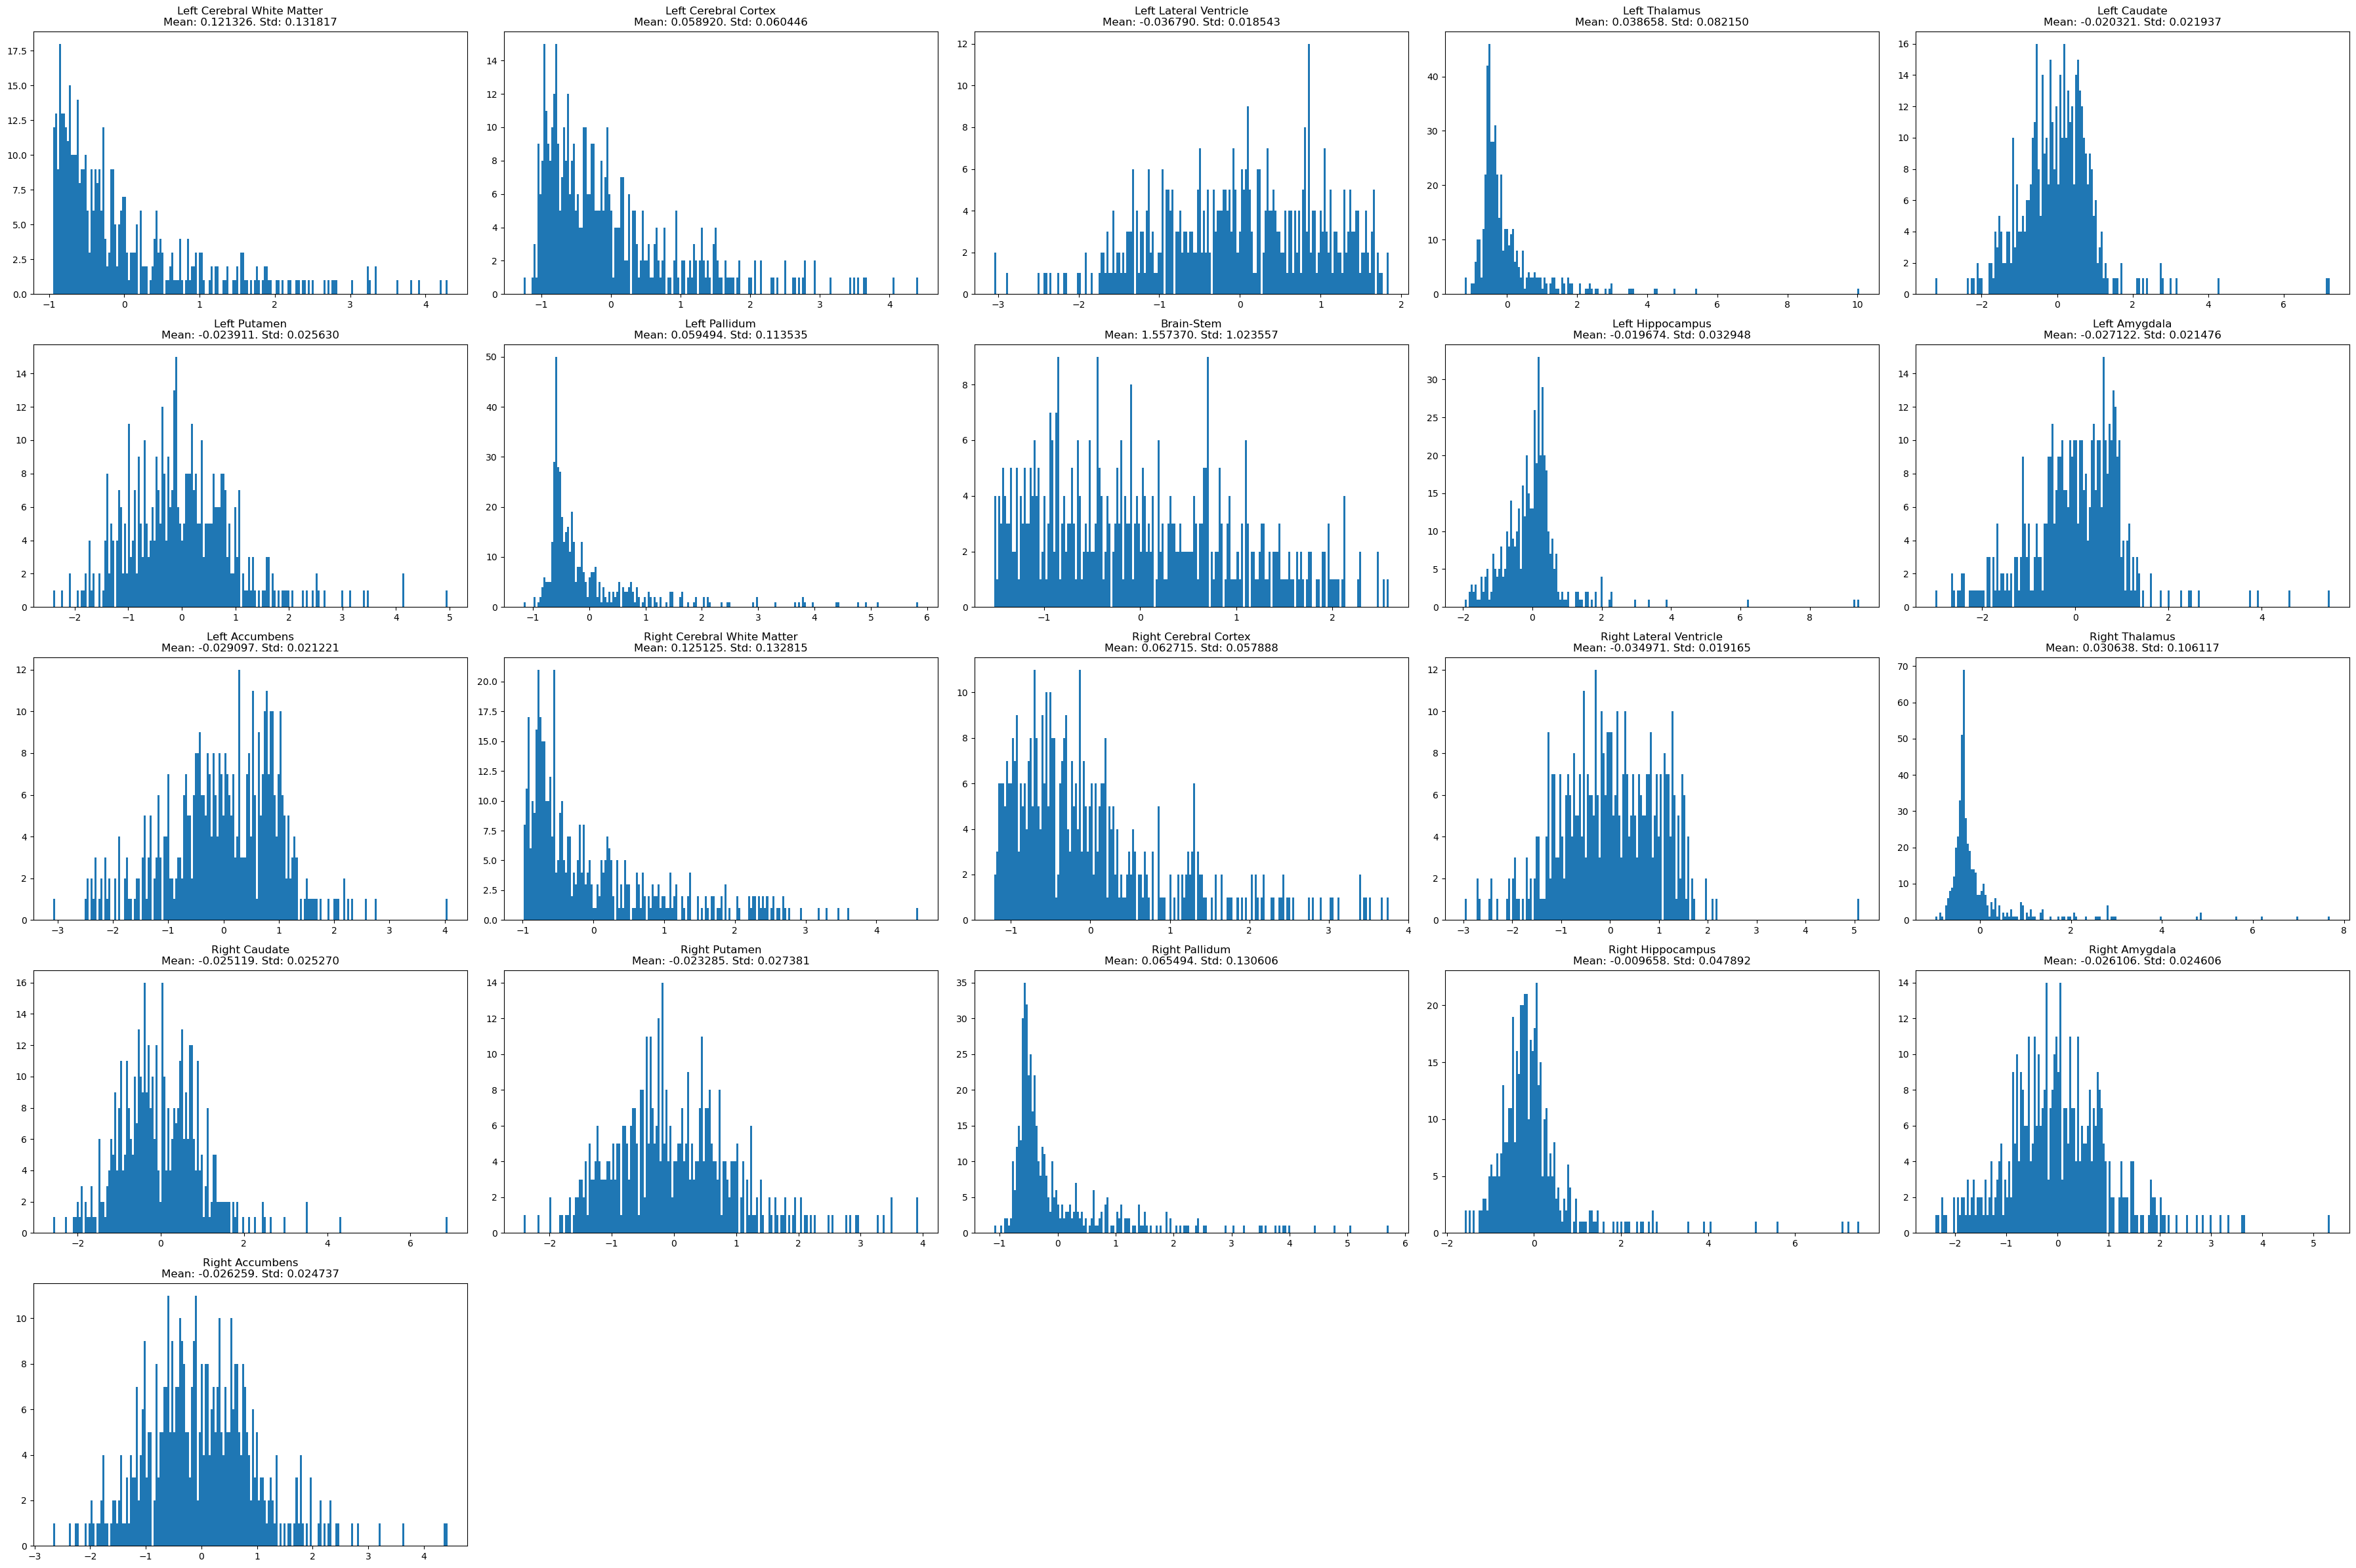

In [303]:
# plotting 
nrows = ncols = int(np.sqrt(int(len(df_filtered.keys()[:-1]))) + 1)

plt.figure(figsize=(36, 24))
for i, ROI in enumerate(df_filtered.keys()[1:]): 
    plt.subplot(nrows, ncols, i+1)
    if np.sum(df_filtered[ROI].values) == 0: 
        standardized = 0
    else:
        standardized = (df_filtered[ROI].values - np.mean(df_filtered[ROI].values)) / np.std(df_filtered[ROI].values) 
    plt.hist(standardized, bins=200)
    plt.title("{}\nMean: {:2f}. Std: {:2f}".format(ROI,np.mean(df_filtered[ROI]), np.std(df_filtered[ROI])))

plt.tight_layout()
plt.show()

    

## extracting number of voxels of resized atlas image per ROI

In [6]:

def extracting_nvox(mask_img_dir): 
    seg_voxels = {}
    # loading mask image
    mask = nib.load(mask_img_dir) 
    mask = np.array(mask.dataobj)
    for i in tqdm(np.unique(mask)): 
        if i == 0: 
            pass 
        else: 
            seg_mask = np.where(mask != i, 0, 1)
            transform = Compose([AddChannel(), Resize((128, 128, 128))])
            seg_mask = transform(seg_mask)[0, :, :, :]
            seg_voxels['%s' % i] = [np.sum(seg_mask)]
    return pd.DataFrame(seg_voxels)




In [13]:
##################
save_dir = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/figures"
roi = "Amygdala"      #options = ['HarvardOxford_Cortical','HarvardOxford_Subcortical', "ReinforcementLearning", "Amygdala"]





# cortical
HarvardOxford_cort_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/HarvardOxford-cort-maxprob-thr25-1mm.nii.gz"
HarvardOxford_cort_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/cort_label.json"

# subcortical
HarvardOxford_subcort_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/HarvardOxford-sub-maxprob-thr25-1mm.nii.gz"
HarvardOxford_subcort_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/HarvardOxford/subcort_label.json"



### microstructures of reinforcement learning (CIT168)
"""
ref: https://osf.io/jkzwp/
"""
ReinforcementLearning_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Reinf_Learn_v1.1.0/CIT168toMNI152-FSL_det.nii.gz"
ReinforcementLearning_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Reinf_Learn_v1.1.0/labels_FullName.json"


### microstructures of amygdala (CIT168)
"""
ref: https://osf.io/hksa6/
"""
Amygdala_mask = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Amygdala_v1.0.3/CIT168_iAmyNuc_1mm_MNI.nii.gz"
Amygdala_LUT = "/Users/wangheehwan/Desktop/CNN_for_BMI/paper/data/clustering/atlas/CIT168_Amygdala_v1.0.3/CIT168_AmyLabels.json"




if roi == 'HarvardOxford_Cortical': 
    mask_img_dir = HarvardOxford_cort_mask
    mask_LUT_dir = HarvardOxford_cort_LUT
elif roi == 'HarvardOxford_Subcortical': 
    mask_img_dir = HarvardOxford_subcort_mask
    mask_LUT_dir = HarvardOxford_subcort_LUT
elif roi == 'ReinforcementLearning':
    mask_img_dir = ReinforcementLearning_mask 
    mask_LUT_dir = ReinforcementLearning_LUT
elif roi == "Amygdala": 
    mask_img_dir = Amygdala_mask 
    mask_LUT_dir = Amygdala_LUT

df = extracting_nvox(mask_img_dir=mask_img_dir)

# indexing ROI name based on the number of ROI 
with open(mask_LUT_dir, 'r') as file:
    LUT = json.load(file) 
df.columns =  list(LUT.values())
df = df.transpose()
df.columns = ['The number of voxels']
df.to_csv(os.path.join(*[save_dir, f'{roi}.csv']))

  0%|          | 0/11 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
100%|██████████| 11/11 [00:00<00:00, 16.56it/s]
